# Exercise 2.1 - Computing Stress Fields with Tensors

### Task
Compute the mechanical equilibrium for an element of a displacement field defined in terms of bilinear shape functions

### Learning goals 
- Familiarize yourself with the PyTorch framework with a hands-on example from mechanics

___
Nesse exemplo utilizaremos 3 bibliotecas do python, então o primeiro bloco de código irá realizar as importações para serem usadas nesse exercício.

In [75]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

**shape functions for bilinear quadrilateral element**
$$
\begin{align}
{N}_1(\xi,\eta) = \frac{1}{4}(1-\xi)(1-\eta), \\[8pt]
{N}_2(\xi,\eta) = \frac{1}{4}(1+\xi)(1-\eta), \\[8pt]
{N}_3(\xi,\eta) = \frac{1}{4}(1+\xi)(1+\eta), \\[8pt]
{N}_4(\xi,\eta) = \frac{1}{4}(1-\xi)(1+\eta)
\end{align}
$$

Representação das fórmulas em expressões lambdas

In [76]:
N1 = lambda xi, eta: 0.25 * (1 - xi) * (1 - eta)
N2 = lambda xi, eta: 0.25 * (1 + xi) * (1 - eta)
N3 = lambda xi, eta: 0.25 * (1 + xi) * (1 + eta)
N4 = lambda xi, eta: 0.25 * (1 - xi) * (1 + eta)

**nodal displacements**

As funções u(xi, eta) e v(xi, eta) realizam a interpolação dos deslocamentos horizontais e verticais com base nos valores nos nós e nas funções de forma. Esses deslocamentos simulam o comportamento da estrutura deformada.

In [77]:
U = [0.0, 1.0, 2.0, 1.0]
V = [0.0, 0.0, 0.5, 0.8]
u = (
    lambda xi, eta:
    N1(xi, eta) * U[0]
    + N2(xi, eta) * U[1]
    + N3(xi, eta) * U[2]
    + N4(xi, eta) * U[3]
)
v = (
    lambda xi, eta: N1(xi, eta) * V[0]
                    + N2(xi, eta) * V[1]
                    + N3(xi, eta) * V[2]
                    + N4(xi, eta) * V[3]
)

**spatial grid creation**

Criamos uma malha 2D em coordenadas naturais (xi, eta) com espaçamento uniforme. As variáveis x e y são tensores 2D com requires_grad=True para permitir o cálculo automático de derivadas.

In [78]:
nx = 5
ny = 5

x = torch.linspace(-1, 1, nx, requires_grad=True)
y = torch.linspace(-1, 1, ny, requires_grad=True)
x, y = torch.meshgrid(x, y, indexing="ij")

**sampled displacement field**

Criamos um tensor d com duas camadas:

- d[0]: deslocamentos na direção u
- d[1]: deslocamentos na direção v

Cada camada tem tamanho (nx, ny), representando os valores interpolados em toda a malha.

In [79]:
d = torch.cat((u(x, y).unsqueeze(0), v(x, y).unsqueeze(0)), 0)
# the following is achieved by the concatenation above
# d[0, :, :] == u(x,y)
# d[1, :, :] == v(x,y)

**gradient computation**

Usamos autograd para obter as derivadas parciais dos deslocamentos em relação às coordenadas espaciais:

- **dd_dx[0, 0]**: ∂u/∂x
- **dd_dx[0, 1]**: ∂u/∂y
- **dd_dx[1, 0]**: ∂v/∂x
- **dd_dx[1, 1]**: ∂v/∂y

Essas derivadas representam o gradiente de deslocamento, essencial para computar as deformações.

In [80]:
dd_dx = torch.zeros((2, 2, nx, ny))
dd_dx[0, 0] = grad(d[0], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
dd_dx[0, 1] = grad(d[0], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
dd_dx[1, 0] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
dd_dx[1, 1] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]

**strain computation**
$$\mathbf{\epsilon} = \frac{1}{2}(\nabla \mathbf{u} + \nabla \mathbf{u}^\intercal)$$

Calculamos o tensor de deformações simétrico (ε), onde:

- ε₁₁ = ∂u/∂x
- ε₂₂ = ∂v/∂y
- ε₁₂ = (∂u/∂y + ∂v/∂x)/2

Essa é a deformação linear utilizada em problemas de elasticidade.

In [81]:
eps = 0.5 * (dd_dx + dd_dx.permute((1, 0, 2, 3)))

**material properties and 4th order material tensor**

Construímos o tensor constitutivo C, que relaciona deformação e tensão via a lei de Hooke para um material isotrópico no plano de tensões. O módulo de elasticidade E e o coeficiente de Poisson ν determinam o comportamento do material.

In [82]:
E = 210000.0
nu = 0.3

C = torch.zeros((2, 2, 2, 2))  # 4th order material tensor
C[0, 0, 0, 0] = 1.0
C[0, 0, 1, 1] = nu
C[1, 1, 0, 0] = nu
C[1, 1, 1, 1] = 1.0
C[0, 1, 0, 1] = (1.0 - nu) / 2.0
C = E / (1.0 - nu ** 2) * C

**stress computation**
$$\mathbf{\sigma} = \mathbf{C} : \mathbf{\epsilon} $$

O resultado é um tensor σ de segunda ordem com componentes:
- σ₁₁, σ₂₂: tensões normais
- σ₁₂ = σ₂₁: tensões de cisalhamento

**equilibrium computation**

Calculamos as forças internas desequilibradas usando a divergência do tensor de tensões. Essas forças representam o desbalanceamento de tensões internas.

Aqui estamos obtendo as derivadas parciais das componentes do tensor de tensões:

**sigma[0, 0] = σ₁₁** → tensão normal na direção x  
**sigma[0, 1] = σ₁₂** → tensão de cisalhamento no plano xy  
**sigma[1, 0] = σ₂₁** → tensão de cisalhamento no plano yx  
**sigma[1, 1] = σ₂₂** → tensão normal na direção y  

Para cada componente, usamos:

grad(<função escalar>, <variável>, grad_outputs=1, create_graph=True)

Ou seja, calcule a derivada da função em relação à variável de interesse, e preserve o grafo computacional para permitir derivadas futuras.

In [83]:
sigma = torch.tensordot(C, eps)

In [84]:
dsigma11_dx = grad(
    sigma[0, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True
)[0]
dsigma12_dy = grad(
    sigma[0, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True
)[0]
dsigma21_dx = grad(
    sigma[1, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True
)[0]
dsigma22_dy = grad(
    sigma[1, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True
)[0]

Com as derivadas das tensões em mãos, calculamos agora o vetor de força interna desequilibrada f:

- **f[0]:** desequilíbrio da equação de equilíbrio na direção x₁
- **f[1]:** desequilíbrio na direção x₂

Isso representa a divergência negativa do tensor de tensões: No contexto de métodos numéricos (como o Método dos Elementos Finitos), esse valor indica o quanto o sistema ainda não está em equilíbrio interno. Em simulações, f é muitas vezes utilizado como resíduo para métodos iterativos de solução.

In [85]:
f = torch.zeros((2, nx, ny))
f[0] = -dsigma11_dx - dsigma12_dy  # out of balance force in x1
f[1] = -dsigma21_dx - dsigma22_dy  # out of balance force in x2

**visualization**

Visualizamos os principais campos calculados na malha com gráficos de contorno:

Linha 1:

$u$: deslocamento horizontal

$-(\nabla \sigma)_1$: força desequilibrada na direção x

$\epsilon_{11}$: deformação normal em x

$\epsilon_{22}$: deformação normal em y

$\epsilon_{12}$: deformação de cisalhamento

Linha 2:

$v$: deslocamento vertical

$-(\nabla \sigma)_2$: força desequilibrada em y

$\sigma_{11}$: tensão normal em x

$\sigma_{22}$: tensão normal em y

$\sigma_{12}$: tensão de cisalhamento

Cada gráfico mostra como esses campos variam ao longo da malha interpolada, permitindo uma análise visual do estado mecânico do sistema.

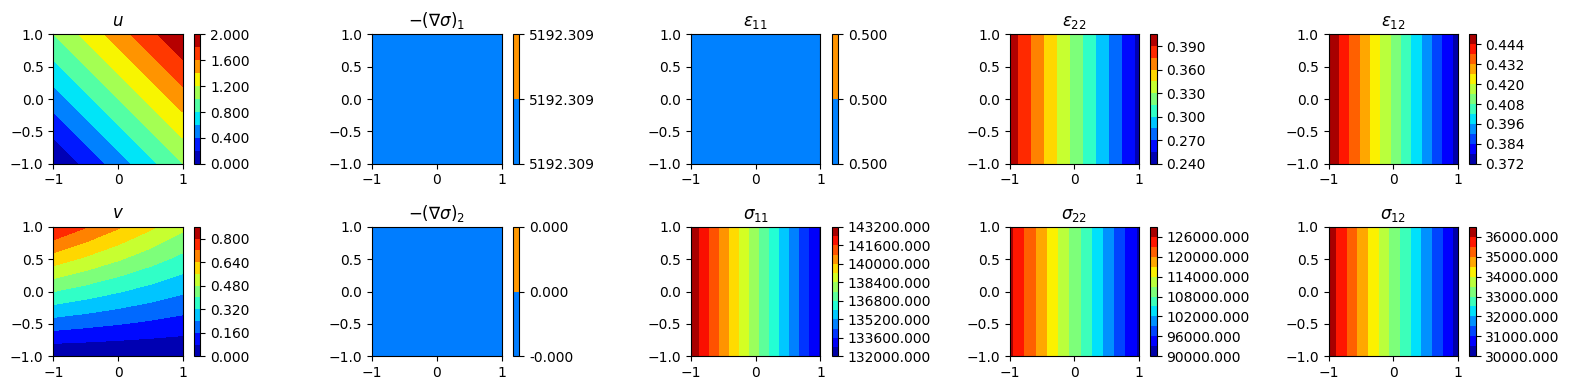

In [86]:
fig, ax = plt.subplots(2, 5, figsize=(16, 4))
title = [
    r"$u$",
    r"$-(\nabla \sigma)_{1}$",
    r"$\epsilon_{11}$",
    r"$\epsilon_{22}$",
    r"$\epsilon_{12}$",
    r"$v$",
    r"$-(\nabla \sigma)_{2}$",
    r"$\sigma_{11}$",
    r"$\sigma_{22}$",
    r"$\sigma_{12}$",
]
data = [
    d[0],
    f[0],
    eps[0, 0],
    eps[1, 1],
    eps[0, 1],
    d[1],
    f[1],
    sigma[0, 0],
    sigma[1, 1],
    sigma[0, 1],
]
i = 0
for i in range(2):
    for j in range(5):
        cp = ax[i, j].contourf(
            x.detach(), y.detach(), data[i * 5 + j].detach(), levels=12, cmap=plt.cm.jet
        )
        fig.colorbar(cp, ax=ax[i, j], format="%.3f")
        ax[i, j].set_aspect("equal")
        ax[i, j].set_title(title[i * 5 + j])

fig.tight_layout()
plt.show()